# **Classifying Samples with Acute Myeloid Leukemia and Acute Lymphoblastic Leukemia: SVM vs XGBoost**

This project is based on a study published in 1999 by Golub et al - Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring. It demonstrated how new cases of cancer could be classified by gene expression monitoring (via DNA microarray) and thus provided a general approach for identifying new cancer classes and assigning tumors to known classes. [1]

The data used in this project, also used as a test case in the paper, is gene expression data from patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). The project's purpose is to train a classifier which would diagnose new patients with one of the two conditions.




## **Data**

### **Data Description**


As mentioned, the dataset used in this project contains microarray gene expression data of patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). The data used in the paper was originally split into two datasets of 38 and 34 samples, used respectively for training and testing. In addition, we had one more dataset with the labels (ALL or AML) for all samples.
The first two columns of the dataset contain gene descriptions.
The dataset contains microarray expression data from 7129 genes, where each gene is a row in the dataset.  Intensity values have been re-scaled such that overall intensities for each chip are equivalent. The samples are the columns of the dataset. Next to the column for each sample there was a column of a variable named "Call", which took three values - "A", "P", and "M". These stand for "Absent", "Present", and "Marginal". They are based on the signal in the microarray for a gene at hand and they determine a gene's expression in a sample. In order for XGBoost to handle these categorical variables, these were transformed into numbers - 0 for "A", 1 for "P", and 2 for "M". We first trained classifiers only with the numerical variables, but they did not perform very well, and thus we trained the classifiers with the numerical and some of the categorical features.

### **Data Loading**

We now proceed to loading the original data and importing the necessary libraries and we will then focus on the data processing steps that will be necessary in this case.


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn import svm


In [3]:
# Load data

labels = "/content/gdrive/My Drive/MLProjects/MolecularCancerClassification/actual.csv"
test_path = "/content/gdrive/My Drive/MLProjects/MolecularCancerClassification/data_set_ALL_AML_independent.csv"
train_path = "/content/gdrive/My Drive/MLProjects/MolecularCancerClassification/data_set_ALL_AML_train.csv"

# replace labels with numbers
labels_df = pd.read_csv(labels, index_col = 'patient')

X_test = pd.read_csv(test_path)
X_train = pd.read_csv(train_path)

### **Data Processing**

There are several data processing steps that need to be conducted.
The first one would be to exctract the "call" columns mentioned above and turn them into features.


In [4]:
# extract only call columns, in order to process them and potentially use them as features
ds_test = [col for col in X_test.columns if 'call' in col]
X_test_call = X_test[ds_test]

# drop call columns from X_test
X_test.drop(ds_test, axis = 1, inplace = True)

# extract only call columns, in order to process them and potentially use them as features
ds_train = [col for col in X_train.columns if 'call' in col]
X_train_call = X_train[ds_train]

# drop call columns from X_test
X_train.drop(ds_train, axis = 1, inplace = True)

In [5]:
# check whether the manipulation above did what was intended
X_train_call.head()
X_test_call.head()

,call,call.1,call.2,call.3,call.4,call.5,call.6,call.7,call.8,call.9,call.10,call.11,call.12,call.13,call.14,call.15,call.16,call.17,call.18,call.19,call.20,call.21,call.22,call.23,call.24,call.25,call.26,call.27,call.28,call.29,call.30,call.31,call.32,call.33
0,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A
1,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A
2,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A
3,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,P,A,A,A,A,A,A,A,A,A
4,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A


In [6]:
# transform the string categories into numbers
X_train_call = X_train_call.replace("A", 0)
X_train_call = X_train_call.replace("P", 1)
X_train_call = X_train_call.replace("M", 2)

X_test_call = X_test_call.replace("A", 0)
X_test_call = X_test_call.replace("P", 1)
X_test_call = X_test_call.replace("M", 2)

In [7]:
# add rownames which include the "Gene Accession number" + "Call"
rownames = "Call " + X_train.iloc[:,1]
X_train_call.index = rownames
X_test_call.index = rownames

# extract ids for patients
ids_train = list(X_train.columns[2:])
ids_test = list(X_test.columns[2:])

X_train_call.columns = ids_train
X_test_call.columns = ids_test

In [8]:
# transpose the "call" features matrices and prepare them for merging with the rest of the features
X_train_call = X_train_call.T
X_train_call.head()

X_test_call = X_test_call.T
X_test_call.head()

Gene Accession Number,Call AFFX-BioB-5_at,Call AFFX-BioB-M_at,Call AFFX-BioB-3_at,Call AFFX-BioC-5_at,Call AFFX-BioC-3_at,Call AFFX-BioDn-5_at,Call AFFX-BioDn-3_at,Call AFFX-CreX-5_at,Call AFFX-CreX-3_at,Call AFFX-BioB-5_st,Call AFFX-BioB-M_st,Call AFFX-BioB-3_st,Call AFFX-BioC-5_st,Call AFFX-BioC-3_st,Call AFFX-BioDn-5_st,Call AFFX-BioDn-3_st,Call AFFX-CreX-5_st,Call AFFX-CreX-3_st,Call hum_alu_at,Call AFFX-DapX-5_at,Call AFFX-DapX-M_at,Call AFFX-DapX-3_at,Call AFFX-LysX-5_at,Call AFFX-LysX-M_at,Call AFFX-LysX-3_at,Call AFFX-PheX-5_at,Call AFFX-PheX-M_at,Call AFFX-PheX-3_at,Call AFFX-ThrX-5_at,Call AFFX-ThrX-M_at,Call AFFX-ThrX-3_at,Call AFFX-TrpnX-5_at,Call AFFX-TrpnX-M_at,Call AFFX-TrpnX-3_at,Call AFFX-HUMISGF3A/M97935_5_at,Call AFFX-HUMISGF3A/M97935_MA_at,Call AFFX-HUMISGF3A/M97935_MB_at,Call AFFX-HUMISGF3A/M97935_3_at,Call AFFX-HUMRGE/M10098_5_at,Call AFFX-HUMRGE/M10098_M_at,...,Call X53065_f_at,Call X64177_f_at,Call X67491_f_at,Call X71345_f_at,Call X97444_f_at,Call Z80780_f_at,Call X00351_f_at,Call X01677_f_at,Call M31667_f_at,Call L41268_f_at,Call X99479_f_at,Call HG658-HT658_f_at,Call M94880_f_at,Call S80905_f_at,Call X03068_f_at,Call Z34822_f_at,Call U87593_f_at,Call U88902_cds1_f_at,Call AC002076_cds2_at,Call D64015_at,Call HG2510-HT2606_at,Call L10717_at,Call L34355_at,Call L78833_cds4_at,Call M13981_at,Call M21064_at,Call M93143_at,Call S78825_at,Call U11863_at,Call U29175_at,Call U48730_at,Call U58516_at,Call U73738_at,Call X06956_at,Call X16699_at,Call X83863_at,Call Z17240_at,Call L49218_f_at,Call M71243_f_at,Call Z78285_f_at
39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,1,0
47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,2,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0


In [9]:
# turn ids from strings to integers
train_ids = X_train_call.index
train_ids = list(map(int, train_ids))

test_ids = X_test_call.index
test_ids = list(map(int, test_ids))

train_labels = []
test_labels = []

for i in train_ids:
  train_labels.append(labels_df.iloc[i-1,0])

for j in test_ids:
  test_labels.append(labels_df.iloc[j-1,0])


train_labels = pd.concat([pd.DataFrame(train_ids), pd.DataFrame(train_labels)], axis=1, ignore_index = False)
train_labels.columns = ["patient", "cancer"]

test_labels = pd.concat([pd.DataFrame(test_ids), pd.DataFrame(test_labels)], axis=1, ignore_index = False)
test_labels.columns = ["patient", "cancer"]

# extract only the labels in the y variables

y_train = train_labels.iloc[:,1]
y_test = test_labels.iloc[:,1]

# replace ALL labels with 0 and AML labels with 1

y_train = y_train.replace("ALL", 0)
y_train = y_train.replace("AML", 1)
y_train = list(y_train)


y_test = y_test.replace("ALL", 0)
y_test = y_test.replace("AML", 1)
y_test = list(y_test)



In [10]:
# processing the numerical features of the train and test sets
gene_names = X_train.iloc[:,1]
X_train = X_train.iloc[:,2:]
X_train = X_train.T
X_train.columns = gene_names
X_train.index = train_ids

X_test = X_test.iloc[:,2:]
X_test = X_test.T
X_test.columns = gene_names
X_test.index = test_ids
X_test.head()


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,48,-591,-622,-342,294,241,-7,-108,45815,57,422,-185,-48,-181,-4,-132,-2,115,41,-50,-202,113,-557,-687,-289,-195,135,267,57,-238,...,429,-605,-2,603,381,2435,20818,12869,835,388,-118,16456,12103,451,3239,-352,41,547,-50,156,41,19,323,420,231,246,533,-101,-451,2112,277,1023,67,214,-135,1074,475,48,168,-70
40,-87,-248,262,295,-226,-493,367,-452,194,162,207,-960,-622,175,171,-71,-163,-445,20958,21,137,-83,30,81,300,-76,-234,-49,24,-52,-370,-35,-616,-409,-417,-589,96,373,-175,-304,...,111,-644,117,-96,288,-23,9499,17954,569,276,-229,18764,10349,204,9883,-304,-109,383,-13,303,117,87,-142,212,5,325,80,-518,-2406,1323,83,529,-295,352,-67,67,263,-33,-33,-21
42,22,-153,17,276,-211,-250,55,-141,0,500,58,-517,-24,-99,13,-77,-182,-150,25880,41,70,-12,37,-15,49,-52,-120,-23,-37,-70,-254,51,-340,-149,-153,-124,194,532,-55,-341,...,186,-770,478,374,363,547,20485,17102,1383,96,189,16180,19089,6,1038,-131,37,355,15,179,87,77,192,235,95,189,243,-189,-3710,826,413,399,16,558,24,893,297,6,1971,-42
47,-243,-218,-163,182,-289,-268,-285,-172,52,-134,-140,-321,-439,-149,-56,117,-31,-243,41275,84,178,-172,-14,-271,73,18,-2,16,-23,102,18,8,-462,-212,-191,52,203,1466,-18,-189,...,172,-224,58,271,205,317,11122,17048,199,147,27,10313,8428,199,3242,-69,8,121,-39,18,-54,-6,-197,262,-16,23,168,-180,-1460,613,174,277,6,81,2,722,170,0,510,-73
48,-130,-177,-28,266,-170,-326,-222,-93,10,159,-3,-643,-502,-129,-31,247,-100,-498,11195,-20,188,-75,-29,-19,150,-119,-82,-63,-44,-24,-232,31,-701,-366,-413,-437,54,650,1453,632,...,114,-541,232,290,322,742,17100,12692,210,226,208,14833,12933,530,1350,-124,7,269,2,200,69,63,147,285,-10,296,413,-146,-677,1475,233,643,51,450,-46,612,370,29,333,-19


Having done the processing step, we now proceed with a brief exploratory data analysis.

## **Exploratory Data Analysis**

Before fitting a machine learning model, it is important to get to know the data. Determining whether there is an imbalance is an important step of exploratory data analysis, as, if left unchecked, it could then affect the performance of the model.

We first check whether there is an imbalance in the train set.

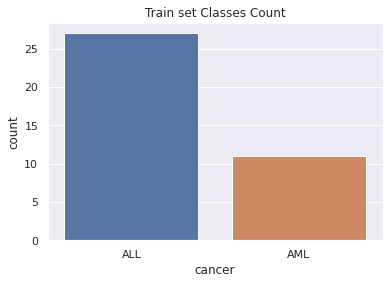

In [11]:
# check numbers of samples in both conditions (ALL and AML), to see if they are balanced
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="cancer", data=train_labels, order = ["ALL", "AML"]).set_title("Train set Classes Count")


As one can see, there is a significant imbalance of ALL to AML samples, which could potentially result into training a classifier which does well on classifying ALL, but not AML samples.

Since the test set was predetermined, it is also worth checking whether it is imbalanced, because this can later on affect the evaluation of the classifier fit.

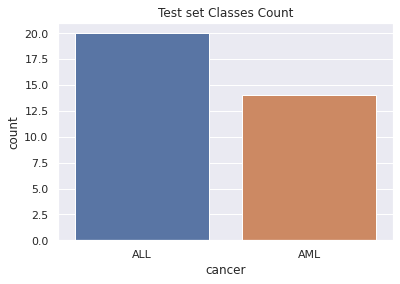

In [12]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="cancer", data=test_labels, order = ["ALL", "AML"]).set_title("Test set Classes Count")

As one can see, both test and train set are imbalanced. Luckily, both GridSearchCV and BayesSearchCV, which we use for parameter optimization of our models both use stratification by default in classification problems.

## **Data Normalization**

Data rescaling is an important step of the process in developing a good machine learning model. Features often have different units, which often means different scales and distributions of feature variables. These differences, if left unadressed, might result in poor performance of the model, hence the problem should be considered. 

There are two rescaling techniques used in machine learning - normalization and standardization.
Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1. This can be thought of as subtracting the mean value or centering the data.
Standardization assumes that observations fit a Gaussian distribution with a well behaved mean and standard deviation. [2] In this case, we decided to use normalization, as we didn't want to make a normality assumption about all 7129 genes.

In [13]:
# Normalize each feature
scaler = MinMaxScaler()

# scale only the numerical features
scaler.fit(X_train)
X_train= scaler.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = gene_names
X_train.index = train_ids
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,0.531440,0.566775,0.435315,0.289720,0.502041,0.365354,0.755011,0.653759,0.915068,0.542526,0.293706,0.444798,0.347973,0.146568,0.304813,0.908629,0.218638,0.388679,0.220747,0.286638,0.839329,0.000000,0.406897,0.498408,0.735450,0.624521,0.192118,0.685864,0.289199,0.106952,0.483402,0.310606,0.884932,0.329825,0.393977,0.173093,0.173464,0.167838,0.676343,0.583472,...,0.627957,0.418498,0.228980,0.020283,0.413793,0.540386,0.620751,0.442092,0.223762,0.525903,0.465856,0.853637,0.675489,0.652025,0.250885,0.318538,0.154982,0.307364,0.146965,0.323151,0.073059,0.362745,0.460417,0.466437,0.283677,0.644670,0.397421,0.394261,0.575549,0.392684,0.475460,0.200840,0.133838,0.141710,0.457317,0.282075,0.269663,0.521212,0.060407,0.438462
2,0.683570,0.827362,0.534965,0.745327,0.565306,0.614173,0.165924,0.671982,0.501370,0.372423,0.398601,0.538217,0.814189,0.849722,0.495544,0.541455,0.136201,0.567296,0.116858,0.351293,0.414868,0.315315,0.117241,0.382166,0.346561,0.463602,0.876847,0.863874,0.554007,0.406417,0.558091,0.310606,0.301370,0.463158,0.289837,0.088597,0.119630,0.073120,0.035793,0.032358,...,0.217204,0.650871,0.212880,0.049304,0.557994,0.517559,0.616143,0.494186,0.209068,0.172684,0.097287,0.799018,0.733900,0.295493,0.114361,0.668407,0.077491,0.247599,0.408946,0.266881,0.392694,1.000000,0.179167,0.234079,0.142631,0.314721,0.218054,0.362380,0.434405,0.118891,0.426380,0.428971,0.358586,0.162987,0.579268,0.276887,0.237828,0.369697,0.024413,0.615385
3,0.811359,0.905537,0.000000,0.806075,0.336735,0.220472,0.570156,0.218679,0.789041,0.000000,0.398601,0.122081,0.000000,0.573284,0.541889,0.994924,0.942652,0.469182,0.261785,0.665948,1.000000,0.045045,0.724138,0.345541,0.928571,0.448276,0.403941,0.704188,0.421603,0.240642,0.244813,0.219697,0.509589,0.428070,0.360100,0.221083,0.315389,0.344002,0.268311,0.213161,...,0.619355,0.500999,0.236136,0.033553,0.805643,0.615452,0.714800,0.583798,0.731738,0.474097,0.540692,0.306347,0.298171,0.710782,0.059865,0.493473,0.435424,0.172892,0.178914,0.427653,0.570776,0.477124,0.405208,0.664372,1.000000,0.555838,0.791325,0.502657,0.589587,0.155759,0.874233,0.682295,0.532828,0.052991,1.000000,0.444811,0.689139,0.551515,0.071987,0.407692
4,0.691684,0.693811,1.000000,0.112150,0.248980,0.322835,0.709354,0.478360,0.358904,0.317010,1.000000,0.335456,0.433559,0.606679,0.424242,0.722504,0.258065,0.972327,0.237972,0.368534,0.736211,0.918919,0.558621,0.585987,0.952381,0.478927,0.172414,0.667539,0.466899,0.272727,0.744813,0.340909,0.591781,0.456140,0.071518,0.117719,0.140837,0.068436,0.230631,0.157093,...,0.468817,0.540394,0.365832,0.020283,0.150470,0.383670,0.509307,0.443938,0.214526,0.618524,0.792329,0.471930,0.590804,0.461495,0.130470,0.234987,0.568266,0.397012,0.252396,0.160772,0.328767,0.081699,0.294792,0.454389,0.412044,0.654822,0.307151,0.379384,0.525778,0.152901,0.644172,0.427572,

## **Principal Component Analysis**

Since there are 7129 numerical features, a natural step would be to attempt dimensionality reduction, using principal component analysis. Now, note that dimensionality reduction would also make sense from biological point of view, as some of the genes might be linked. We decided to use 30 principal components, as this helps explain around 90 percent of the variance, which is very reasonable.

In [14]:
n_components = 30
pca = PCA(n_components = n_components)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,4.335955,1.873971,-4.492073,0.773770,-2.641525,4.426485,-1.742736,1.060366,-1.985917,2.537553,-2.932625,1.502400,3.065318,-1.588214,-0.305211,5.320206,8.588535,-2.194339,4.668735,0.596885,0.811086,-1.476379,0.281762,-0.586919,-3.808656,-1.267276,1.592440,-2.155034,1.507355,2.538646
1,-1.888290,2.243604,2.894183,1.310716,3.339522,-4.195679,0.379701,1.530271,0.615044,2.551174,1.822719,0.612448,5.792718,-0.962809,-4.574907,-2.097889,-3.339450,-0.066150,2.359363,-1.508171,-2.305903,1.370054,-3.205514,-0.413319,-3.610300,-2.110314,5.401324,2.236673,3.129337,-1.052334
2,12.031244,3.846473,-6.740047,9.491940,-0.144719,-1.574215,-5.980327,3.808565,1.018972,0.438956,0.719253,3.145914,0.034067,-4.200813,1.105623,6.347269,-4.480304,2.334223,-4.752565,-2.881092,0.629572,1.449634,1.107507,0.425798,0.150408,0.616999,-0.195955,0.292101,-0.390007,1.498904
3,3.429125,-1.189050,-5.278071,0.613200,0.322281,3.302466,7.713025,-0.653048,-2.128099,-4.104544,-2.974488,0.883549,-0.526229,-0.768457,-0.413659,0.684794,1.096109,-1.056898,-2.197284,0.952219,0.573854,5.971599,1.199560,-1.409250,5.358893,-3.884200,2.303694,0.739769,4.377079,-2.296540
4,-8.867465,7.034777,1.061889,0.976604,0.632451,2.662190,1.001255,-0.258231,-1.865961,-0.411062,-1.586146,4.408844,-0.954805,1.821213,0.516229,-0.851119,-1.169675,-0.152600,-0.351507,-0.635984,1.557372,0.253278,1.274607,-0.047487,0.203232,1.291862,-0.745854,-0.750269,0.448097,3.040338


In [15]:
X_train_pca.reset_index(drop = True, inplace = True)
X_train_pca.columns =['PC'+str(i) for i in range(1,n_components+1)]
print("Percent of explained variance with {n_components} Components : ", round(pca.explained_variance_ratio_.sum()*100,2))


Percent of explained variance with {n_components} Components :  93.02


Once this is done for the train set, we also normalize the test set (separately, as doing the normalization for both sets together could potentially lead to some data leakage). Then we reduce the dimensionality of the test set by projecting the test points into the space defined by the principal components extracted from the train set.

In [16]:
# Normalize test set and reduce dimensions through PCA

# Normalize

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = gene_names
X_test.index = test_ids

# PCA Transform
X_test_pca = pca.transform(X_test)

# generate the matrix with BOTH numerical and categorical features
X_test_pca = pd.DataFrame(X_test_pca)
X_test_pca.reset_index(drop=True, inplace=True)
X_test_pca.columns =['PC'+str(i) for i in range(1,n_components+1)]
X_test_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,0.265514,-3.207727,-2.786487,-1.702472,-2.083942,2.528115,-3.593685,1.640996,-0.429948,1.691263,0.781859,-0.095082,0.681813,-1.551948,-0.249202,-0.458965,1.692169,0.540758,-1.322293,-0.289083,0.049336,-1.589160,-0.111749,1.116507,-0.529986,-0.311122,-0.109920,-0.097864,0.024262,-2.232136
1,0.311540,-5.013775,-4.847889,-2.141858,0.494876,2.121151,0.521835,-2.747256,4.109137,-1.451260,1.862176,0.827363,-0.913557,0.987720,-0.792933,1.941781,0.312634,-0.825685,1.317022,0.892502,0.138669,0.111230,0.151552,0.074872,-0.264839,-0.868477,-0.133165,0.636512,-0.607513,-1.209986
2,-4.169704,-1.028255,3.713443,-3.610079,-2.051088,-3.571384,0.577837,0.177006,-1.160565,2.299942,0.524400,-0.166879,-1.407586,1.618213,-0.290944,1.625727,-0.119102,0.622332,-0.399451,-1.032814,-0.716187,-1.729384,-1.124953,-0.686694,0.176910,-1.892837,-0.847839,1.005687,0.001534,-0.058760
3,-9.322889,-0.710645,0.340301,-1.982827,-1.071503,1.015475,-1.595842,-1.438380,-0.483306,0.182238,0.224417,-0.485442,-1.352547,0.088184,0.208357,0.871859,-0.322045,-0.048135,-0.293665,-0.319171,0.612974,-0.560726,-0.285509,0.335248,0.300353,0.290180,0.226227,0.191011,-0.507486,-0.626496
4,-3.561558,10.602597,-0.151345,-0.831934,-1.669646,2.056914,0.223678,0.659193,-0.212873,-0.645871,-1.112736,0.389284,-0.731572,0.996058,0.525264,2.146968,0.124842,-0.204713,-0.622930,-0.275353,-0.658744,-1.317123,-0.633039,-2.333087,-0.324985,-2.568342,-1.082965,3.582604,-1.942982,-0.442201


Now, before proceeding to the model fitting part, first we need to pick a suitable performance metric.

## **Choosing a Performance Metric**

Choosing a suitable performance metric is a crucial part of every machine learning project. In order to select a good metric, we first need to clearly state the purpose of our model.

In the case of classifying patients with either ALL or AML diagnosis, the performance of the model in **classifying samples from each of the classes is equally important**. This is, we want a metric which places equal weight on classification performance for each class. We are also **interested in high precision and recall for each of the classes**.  Having these requirements in mind, we decided that a good choice in this case would be to use the **Macro F1-score**. The Macro F1-score is the unweighted average of the F1-score calculated for each of the classes. Using it would enable us to find the model which fits best our requirements. Moreover, this metric works well for our imbalanced dataset, as it would penalize the misclassification of samples from the minority class - in our case AML. This is useful, because it would prevent from obtaining an overly optimistic performance evaluation, in case a model is trained to do well on classifying samples from the majority class only.
Having chosen our evaluation metric, we now proceed to model fitting.


## **Model Fitting**

In this project we decided to compare the performance of XGBoost and SVM Classifiers. We decided also, purely for the sake of exercise, to do parameter optimization using grid search and Bayesian optimization for SVM and XGBoost, respectively. Since we have both a set of numerical and a large set of categorical variables, we decided to do some experimentation with the set of features we used to fit the classifiers. Thus, we would first fit models only with the numerical features and then experiment with adding some of the categorical variables, in order to try and improve the model performance. 

### **Fitting Models Only with the Numerical Features**

In this section we are going to fit an SVM classifier and an XGBoost classifier, using only the numerical features.

#### **SVM**

We decided, purely for the sake of exercise, to tune the hyperparameters of the SVM classifier trained, using GridSearchCV.


##### **Grid Search Hyperparameter Tuning**

In [17]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [1e-4, 1e-2, 1, 5, 10],
                     'C': [1e-1, 1, 10, 100, 1000]},]

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring = scoring, refit = 'f1_macro')
clf.fit(X_train_pca, y_train)
print("Best parameters set through GridSearchCV")
print()
print(clf.best_params_)


Best parameters set through GridSearchCV

{'C': 0.1, 'kernel': 'linear'}


As mentioned earlier, our dataset is imbalanced (there are more ALL than AML samples in both the train and test set. Hence it is very important to ensure that the splitof the train sample during the cross-validation used is stratified. Luckily, GridSearchCV does this by default. In addition, we used a 5-fold cross-validation, as our train set is not very big and we wanted to ensure that we still had several samples to tune our hyperparameters on. We used the macro f1-score, in order to evaluate our models.

We then use the best hyperparameter values and instantiate the best model.

##### **Best Model Fitting**

In [18]:
# Instantiating Best Model
clf = svm.SVC(kernel='linear', C = 0.1)
clf.fit(X_train_pca, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

We then use the trained model to classify samples in the test set.

In [19]:
# Generate predictions for test samples
y_pred = clf.predict(X_test_pca)


##### **Model Evaluation**

In [20]:
# Calculate model performance metrics on test set

print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label:")
print()
print(" ALL       AML")

print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.7984189723320159

F1-score for each label:

 ALL       AML
[0.86956522 0.72727273]


This is a reasonable performance result, although there is clearly room for improvement. As it can be expected, the F1-score for AML is lower, as we had almost 2:1 ratio of ALL to AML samples in the train set. In order to get a better idea of the performance of the trained classifier, it is worth investigating how well the model does, compared to a one-outcome-only prediction for all samples (only ALL or only AML.)

##### **Model Performance Comparison to One-Outcome-Only Predictions**

In [21]:
# generate vectors will all 1s (i.e AML) or all 0s (i.e ALL)
aml = [1] * len(y_pred)
all = [0] * len(y_pred)

In [22]:
# macro score of only-ALL macro F1-score
print("Macro F1-Score of only-ALL predictions")
print(f1_score(y_test, all, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, all, average = None))

Macro F1-Score of only-ALL predictions
0.37037037037037035

F1-score for each label

 ALL       AML
[0.74074074 0.        ]


Now, it is worth pointing out, that when considering an only-ALL-predictions set, the F1-score for AML samples predictions is not defined, as both Precision and Recall are 0, which means that AML F1-score is 0/0. In this case, however, sklearn assigns AML F1-score = 0, thus still meaning in has no contribution to the macro F1 score, thus bringing its value down. Hence, we decided to stick to macro F1-score as an evaluation metric.

As one can see, our SVM classifier does significantly better in classifying samples, compared to an only-ALL-predictions dataset.

We also need to check how it does against an only-AML-predictions dataset.

In [23]:
print("Macro F1-Score of only-ALL predictions")
print(f1_score(y_test, aml, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, aml, average = None))

Macro F1-Score of only-ALL predictions
0.2916666666666667

F1-score for each label

 ALL       AML
[0.         0.58333333]


Unsurprisingly, our model does better, compared to an only-AML-predictions dataset.

#### **XGBoost Classifier**

In [24]:
pip install scikit-optimize

##### **Bayesian Optimization Hyperparameter Tuning**

In [25]:
import skopt 
from skopt import BayesSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

parameters = {'n_estimators': skopt.space.Integer(0,100),
        'min_num_child': skopt.space.Integer(0, 50,),
        'max_depth': skopt.space.Integer(0, 10),
        'subsample': skopt.space.Real(0.5, 1.0),
        'colsample_bytree': skopt.space.Real(0.5, 1.0),
        'reg_lambda': skopt.space.Real(1e-10,100,'log-uniform'),
        'reg_alpha': skopt.space.Real(1e-10,100,'log-uniform'),
        'learning-rate': skopt.space.Real(0.01,0.2,'log-uniform'),
        }

bayes = BayesSearchCV(xgb.XGBClassifier(), search_spaces= parameters, n_iter=10, scoring='f1_macro',cv=5,random_state=0)
res = bayes.fit(X_train_pca, y_train)
print(res.best_params_)

OrderedDict([('colsample_bytree', 0.7643458710377254), ('learning-rate', 0.011893969796789843), ('max_depth', 3), ('min_num_child', 10), ('n_estimators', 24), ('reg_alpha', 1.2750414511557992e-06), ('reg_lambda', 0.005068685293864641), ('subsample', 0.7042865059246077)])


##### **Best Model Fitting**

In [26]:
final_params={'objective': 'binary:logistic', 'n_estimators': 24, 'colsample_bytree': 0.7643458710377254, 'learning-rate': 0.011893969796789843,'max_depth': 3, 'min_num_child': 10, 'reg_alpha': 1.2750414511557992e-06, 'reg_lambda': 0.005068685293864641 , 'subsample': 0.7042865059246077,}
dtrain = xgb.DMatrix(X_train_pca, y_train)
model_xgb = xgb.train(final_params,dtrain=dtrain)

In [27]:
dtest = xgb.DMatrix(X_test_pca, y_test)
y_pred = model_xgb.predict(dtest)
# turn the probabilities into labels
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

##### **Model Evaluation**

In [28]:
print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.8068181818181818

F1-score for each label

 ALL       AML
[0.86363636 0.75      ]


As one can see, the XGBoost Classifier performs almost as well in classifying the samples from the two classes, compared to the SVM Classifier. 

It also does better than the only-ALL-predictions and only-AML-predictions, which have macro F1-scores of 0.37 and 0.29, respectively.

We will now try and imporve the performance of both classifiers by adding some extra categorical variables.

### **Fitting Models with Both Numerical and Categorical Features**

There are 7129 categorical variables, whose values denote whether the signal from a gene is strong enough for it to be qualified as expressed ("P" - present), absent ("A"), or marginal ("M"). In order for the classifier to be able to process these categorical features, they were encoded with numbers - 1, 0, and 2, respectively. Now, since this is a very large number of features (considering that we only have 38 train samples), we needed to carefully select a small subset of the categorical variables to add to the set of numerical features.

The idea we tried out was to find differentially expressed genes between the two groups (ALL and AML) from the provided gene expression microarray data of the train set.
The categorical variables, corresponding to these  genes will be added to the numerical features. Since there is a well-established package for microarray expression data in R - limma, it was used. The data was already normalized, so this step was skipped.

#### **Categorical Variables Selection**

We selected the 10 differentially expressed genes in the train set with the smallest p-value, after Benjamini-Hochberg adjustment. These were (in order of smallest to largest adj. p-value): *U50136_rna1_at, X95735_at, M55150_at, M16038_at, Y12670_at, M23197_at, X17042_at, U82759_at, D49950_at, M84526_at*. The categorical variables, corresponding to these variables were extracted and added to the numerical variables.

In [29]:
# extract the categorical variables, which correspond to the top 10 differentially expressed genes between the two classes
X_train_de = X_train_call[["Call U50136_rna1_at", "Call X95735_at", "Call M55150_at", "Call M16038_at", "Call Y12670_at", "Call M23197_at", "Call X17042_at", "Call U82759_at", "Call D49950_at", "Call M84526_at"]]
X_test_de = X_test_call[["Call U50136_rna1_at", "Call X95735_at", "Call M55150_at", "Call M16038_at", "Call Y12670_at", "Call M23197_at", "Call X17042_at", "Call U82759_at", "Call D49950_at", "Call M84526_at"]]
X_train_de.reset_index(drop = True, inplace = True)
X_test_de.reset_index(drop = True, inplace = True)


In [30]:
# add the "de" categorical variables to the numerical variables 
X_train_all = pd.concat([X_train_pca, X_train_de], axis=1, sort=False)
X_test_all = pd.concat([X_test_pca, X_test_de], axis=1, sort=False)


In [31]:
X_train_all.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,Call U50136_rna1_at,Call X95735_at,Call M55150_at,Call M16038_at,Call Y12670_at,Call M23197_at,Call X17042_at,Call U82759_at,Call D49950_at,Call M84526_at
0,4.335955,1.873971,-4.492073,0.773770,-2.641525,4.426485,-1.742736,1.060366,-1.985917,2.537553,-2.932625,1.502400,3.065318,-1.588214,-0.305211,5.320206,8.588535,-2.194339,4.668735,0.596885,0.811086,-1.476379,0.281762,-0.586919,-3.808656,-1.267276,1.592440,-2.155034,1.507355,2.538646,0,0,0,1,0,0,1,0,0,0
1,-1.888290,2.243604,2.894183,1.310716,3.339522,-4.195679,0.379701,1.530271,0.615044,2.551174,1.822719,0.612448,5.792718,-0.962809,-4.574907,-2.097889,-3.339450,-0.066150,2.359363,-1.508171,-2.305903,1.370054,-3.205514,-0.413319,-3.610300,-2.110314,5.401324,2.236673,3.129337,-1.052334,0,0,1,1,0,0,1,0,0,0
2,12.031244,3.846473,-6.740047,9.491940,-0.144719,-1.574215,-5.980327,3.808565,1.018972,0.438956,0.719253,3.145914,0.034067,-4.200813,1.105623,6.347269,-4.480304,2.334223,-4.752565,-2.881092,0.629572,1.449634,1.107507,0.425798,0.150408,0.616999,-0.195955,0.292101,-0.390007,1.498904,0,0,2,0,0,0,1,0,0,0
3,3.429125,-1.189050,-5.278071,0.613200,0.322281,3.302466,7.713025,-0.653048,-2.128099,-4.104544,-2.974488,0.883549,-0.526229,-0.768457,-0.413659,0.684794,1.096109,-1.056898,-2.197284,0.952219,0.573854,5.971599,1.199560,-1.409250,5.358893,-3.884200,2.303694,0.739769,4.377079,-2.296540,0,0,0,1,1,0,1,0,0,0
4,-8.867465,7.034777,1.061889,0.976604,0.632451,2.662190,1.001255,-0.258231,-1.865961,-0.411062,-1.586146,4.408844,-0.954805,1.821213,0.516229,-0.851119,-1.169675,-0.152600,-0.351507,-0.635984,1.557372,0.253278,1.274607,-0.047487,0.203232,1.291862,-0.745854,-0.750269,0.448097,3.040338,0,0,1,1,1,1,1,0,0,0


Now that we have selected and added the categorical variables to the set of numeric features, we proceed with training an SVM and XGBoost classifiers once again, in order to try and improve the results.

#### **SVM**

##### **Grid Search Hyperparameter Tuning**

In [32]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['linear'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'C': [1e-1, 1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [1e-4, 1e-2, 1, 5, 10],
                     'C': [1e-1, 1, 10, 100, 1000]},]

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring = scoring, refit = 'f1_macro')
clf.fit(X_train_all, y_train)
print("Best parameters set through GridSearchCV")
print()
print(clf.best_params_)

Best parameters set through GridSearchCV

{'C': 0.1, 'kernel': 'linear'}


##### **Best Model Fitting**

In [33]:
# Instantiating Best Model
clf = svm.SVC(kernel='linear', C = 0.1)
clf.fit(X_train_all, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##### **Model Evaluation**

In [34]:
# Generate predictions for test samples
y_pred = clf.predict(X_test_all)


In [35]:
# Calculate model performance metrics on test set

print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))



Macro F1-Score
0.7984189723320159

F1-score for each label

 ALL       AML
[0.86956522 0.72727273]


As one can see, adding the categorical variables does not change the performance of the SVM classifier.

#### **XGBoost Classifier**

##### **Bayesian Optimization Hyperparameter Tuning**

In [36]:
import skopt 
from skopt import BayesSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

parameters = {'n_estimators': skopt.space.Integer(0,100),
        'min_num_child': skopt.space.Integer(0, 50,),
        'max_depth': skopt.space.Integer(0, 10),
        'subsample': skopt.space.Real(0.5, 1.0),
        'colsample_bytree': skopt.space.Real(0.5, 1.0),
        'reg_lambda': skopt.space.Real(1e-10,100,'log-uniform'),
        'reg_alpha': skopt.space.Real(1e-10,100,'log-uniform'),
        'learning-rate': skopt.space.Real(0.01,0.2,'log-uniform'),
        }

bayes = BayesSearchCV(xgb.XGBClassifier(objective = 'binary:logistic'), search_spaces= parameters, n_iter=10, scoring='f1_macro',cv=5,random_state=0)
res = bayes.fit(X_train_all,y_train)
print(res.best_params_)

OrderedDict([('colsample_bytree', 0.6162570141151325), ('learning-rate', 0.020729429554412183), ('max_depth', 7), ('min_num_child', 14), ('n_estimators', 18), ('reg_alpha', 1.1046982314481511e-07), ('reg_lambda', 1.551926920387429e-10), ('subsample', 0.5148603857041089)])


##### **Best Model Fitting**

In [37]:
final_params={'objective': 'binary:logistic', 'n_estimators': 18, 'colsample_bytree': 0.6162570141151325, 'learning-rate': 0.020729429554412183,'max_depth': 7, 'min_num_child': 14, 'reg_alpha': 1.1046982314481511e-07, 'reg_lambda': 1.551926920387429e-10 , 'subsample': 0.5148603857041089}
dtrain = xgb.DMatrix(X_train_all, y_train)
model_xgb_pca_num_cat_de = xgb.train(final_params, dtrain = dtrain)


##### **Model Evaluation**

In [38]:
dtest = xgb.DMatrix(X_test_all, y_test)
y_pred = model_xgb_pca_num_cat_de.predict(dtest)
# turn the probabilities into labels
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [39]:
print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.8418604651162791

F1-score for each label

 ALL       AML
[0.88372093 0.8       ]


It seems like adding the categorical features resulted in a slight improvement of the performance of the XGBoost classifier, making this also an overall well-performing classification model, at least based on our test data. As one can see, this model does reasonably well in classifying samples from both the ALL and AML classes, which is exactly what we set as a goal at the beginning of the project.

Now, one cannot help but ask how well a model with a reduced number of features would do. Thus, we are now going to train a classifier with only the categorical variables, corresponding to the top 10 differentially expressed genes, as well as a model with said categorical variables, as well as the numerical variables, corresponding to these 10 genes. We will also experiment with a classifier trained on both the numerical and categorical features that correspond to the DE genes.

### **Fitting a Model with Numerical and Categorical Features Corresponding to DE Genes**

Taking differentially expressed genes into account seems to add some extra information and improves the performance of the XGBoost classfier. Thus we are now going to train an XGBoost classifier, which uses the DE categorical variables, as well as the numerical variables, corresponding to the 10 differentially expressed genes mentioned above.

In [40]:
# extract the numerical variables, which correspond to the top 10 differentially expressed genes between the two classes
X_train_num_de = X_train[["U50136_rna1_at", "X95735_at", "M55150_at", "M16038_at", "Y12670_at", "M23197_at", "X17042_at", "U82759_at", "D49950_at", "M84526_at"]]
X_test_num_de = X_test[["U50136_rna1_at", "X95735_at", "M55150_at", "M16038_at", "Y12670_at", "M23197_at", "X17042_at", "U82759_at", "D49950_at", "M84526_at"]]
X_train_num_de.reset_index(drop = True, inplace = True)
X_test_num_de.reset_index(drop = True, inplace = True)



In [41]:
# add the "de" categorical variables to the numerical variables 
X_train_all_de = pd.concat([X_train_num_de, X_train_de], axis=1, sort=False)
X_test_all_de = pd.concat([X_test_num_de, X_test_de], axis=1, sort=False)

In [42]:
import skopt 
from skopt import BayesSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

parameters = {'n_estimators': skopt.space.Integer(0,100),
        'min_num_child': skopt.space.Integer(0, 50,),
        'max_depth': skopt.space.Integer(0, 10),
        'subsample': skopt.space.Real(0.5, 1.0),
        'colsample_bytree': skopt.space.Real(0.5, 1.0),
        'reg_lambda': skopt.space.Real(1e-10,100,'log-uniform'),
        'reg_alpha': skopt.space.Real(1e-10,100,'log-uniform'),
        'learning-rate': skopt.space.Real(0.01,0.2,'log-uniform'),
        }

bayes = BayesSearchCV(xgb.XGBClassifier(objective = 'binary:logistic'), search_spaces= parameters, n_iter=10, scoring='f1_macro',cv=5,random_state=0)
res = bayes.fit(X_train_all_de,y_train)
print(res.best_params_)

OrderedDict([('colsample_bytree', 0.6162570141151325), ('learning-rate', 0.020729429554412183), ('max_depth', 7), ('min_num_child', 14), ('n_estimators', 18), ('reg_alpha', 1.1046982314481511e-07), ('reg_lambda', 1.551926920387429e-10), ('subsample', 0.5148603857041089)])


In [43]:
# train the model with tuned hyperparameters
final_params={'objective': 'binary:logistic', 'n_estimators': 18, 'colsample_bytree': 0.6162570141151325, 'learning-rate': 0.020729429554412183,'max_depth': 7, 'min_num_child': 14, 'reg_alpha': 1.1046982314481511e-07, 'reg_lambda': 1.551926920387429e-10 , 'subsample': 0.5148603857041089}
dtrain = xgb.DMatrix(X_train_de, y_train)
model_xgb_de_num_cat = xgb.train(final_params, dtrain = dtrain)


In [44]:
# testing the trained classifier
dtest = xgb.DMatrix(X_test_de, y_test)
y_pred = model_xgb_de_num_cat.predict(dtest)
# turn the probabilities into labels
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [45]:
print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.7235772357723578

F1-score for each label

 ALL       AML
[0.7804878  0.66666667]


As one can see the XGBoost classifier trained only with the numerical and categorical features corresponding to DE genes performs worse, compared to the XGBoost and SVM algorithms trained on the PCA features and the categorical variables.


Nevertheless, it is worth experimenting further to see whether we can get a reduced number of features and an on-par or better performance with the best classifiers so far. 

### **Fitting a Model Only with the Numerical Features Corresponding to DE Genes**

In [46]:
import skopt 
from skopt import BayesSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

parameters = {'n_estimators': skopt.space.Integer(0,100),
        'min_num_child': skopt.space.Integer(0, 50,),
        'max_depth': skopt.space.Integer(0, 10),
        'subsample': skopt.space.Real(0.5, 1.0),
        'colsample_bytree': skopt.space.Real(0.5, 1.0),
        'reg_lambda': skopt.space.Real(1e-10,100,'log-uniform'),
        'reg_alpha': skopt.space.Real(1e-10,100,'log-uniform'),
        'learning-rate': skopt.space.Real(0.01,0.2,'log-uniform'),
        }

bayes = BayesSearchCV(xgb.XGBClassifier(objective = 'binary:logistic'), search_spaces= parameters, n_iter=10, scoring='f1_macro',cv=5,random_state=0)
res = bayes.fit(X_train_num_de,y_train)
print(res.best_params_)

OrderedDict([('colsample_bytree', 0.6162570141151325), ('learning-rate', 0.020729429554412183), ('max_depth', 7), ('min_num_child', 14), ('n_estimators', 18), ('reg_alpha', 1.1046982314481511e-07), ('reg_lambda', 1.551926920387429e-10), ('subsample', 0.5148603857041089)])


In [47]:
final_params={'objective': 'binary:logistic', 'n_estimators': 18, 'colsample_bytree': 0.6162570141151325, 'learning-rate': 0.020729429554412183,'max_depth': 7, 'min_num_child': 14, 'reg_alpha': 1.1046982314481511e-07, 'reg_lambda': 1.551926920387429e-10 , 'subsample': 0.5148603857041089}
dtrain = xgb.DMatrix(X_train_num_de, y_train)
model_xgb = xgb.train(final_params, dtrain = dtrain)


In [48]:
dtest = xgb.DMatrix(X_test_num_de, y_test)
y_pred = model_xgb.predict(dtest)
# turn the probabilities into labels
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [49]:
print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.7984189723320159

F1-score for each label

 ALL       AML
[0.86956522 0.72727273]


This classifier performs overall reasonably well on the test set, however there is a significant difference in the performance on the ALL and AML samples, when looked at separately. 

### **Fitting a Model Only with the Categorical Features Corresponding to DE Genes**

In [50]:
import skopt 
from skopt import BayesSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

parameters = {'n_estimators': skopt.space.Integer(0,100),
        'min_num_child': skopt.space.Integer(0, 50,),
        'max_depth': skopt.space.Integer(0, 10),
        'subsample': skopt.space.Real(0.5, 1.0),
        'colsample_bytree': skopt.space.Real(0.5, 1.0),
        'reg_lambda': skopt.space.Real(1e-10,100,'log-uniform'),
        'reg_alpha': skopt.space.Real(1e-10,100,'log-uniform'),
        'learning-rate': skopt.space.Real(0.01,0.2,'log-uniform'),
        }

bayes = BayesSearchCV(xgb.XGBClassifier(objective = 'binary:logistic'), search_spaces= parameters, n_iter=10, scoring='f1_macro',cv=5,random_state=0)
res = bayes.fit(X_train_de,y_train)
print(res.best_params_)

OrderedDict([('colsample_bytree', 0.5737099059755859), ('learning-rate', 0.10448475115917014), ('max_depth', 5), ('min_num_child', 23), ('n_estimators', 82), ('reg_alpha', 0.0139529144831671), ('reg_lambda', 1.4176986367221247), ('subsample', 0.6597195969050774)])


In [51]:
final_params={'objective': 'binary:logistic', 'n_estimators': 82, 'colsample_bytree': 0.5737099059755859, 'learning-rate': 0.10448475115917014,'max_depth': 5, 'min_num_child': 23, 'reg_alpha': 0.0139529144831671, 'reg_lambda': 1.4176986367221247 , 'subsample': 0.6597195969050774}
dtrain = xgb.DMatrix(X_train_de, y_train)
model_xgb_cat_de = xgb.train(final_params, dtrain = dtrain)


In [52]:
dtest = xgb.DMatrix(X_test_de, y_test)
y_pred = model_xgb_cat_de.predict(dtest)
# turn the probabilities into labels
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

In [53]:
print("Macro F1-Score")
print(f1_score(y_test, y_pred, average = "macro"))
print()
print("F1-score for each label")
print()
print(" ALL       AML")
print(f1_score(y_test, y_pred, average = None))


Macro F1-Score
0.8754578754578755

F1-score for each label

 ALL       AML
[0.9047619  0.84615385]


As one can see, this classifier performs slightly better than the classifier trained with both the PCA numerical and the categorical features corresponding to the DE genes.
However, there is one thing that should be considered when thinking of only using the categorical variables. We are not very clear on what the threshold is for determining the expression of a gene as present ("P"), absent ("A"), or marginal ("M"). And it is not very clear how robust this categorization is.

## **Comparison of All Classifiers**

For convenience, here is a table of the performance results of all classifiers trained in this project.

| | Algorithm          | Features | Num Features | Macro F1-score |ALL F1-score | AML F1-Score |
|--|--------------------|----------|----------|---------|----------|----------|
|1|SVM                 | PCA Num  | 30       | **0.798**  | 0.870   | 0.727  |
|2|XGBoost             | PCA Num  | 30       | **0.807**  | 0.864   | 0.750   |
|3|SVM                 | PCA Num + DE Cat   | 40   | **0.798**  | 0.870   | 0.727|
|4|XGBoost             | PCA Num + DE Cat   | 40   | **0.842**  | 0.884  | 0.800|
|5|XGBoost             | DE Num + DE Cat   | 20   | **0.724**  | 0.780  | 0.667|
|6|XGBoost             | DE Num | 10   | **0.798** | 0.870  | 0.727   |
|7|XGBoost             | DE Cat| 10   | **0.875**  | 0.905   | 0.846 | 

Looking at the table, one can see that the top two classifiers, in terms of macro F1-score calculated on the test set, are Model 4 and Model 7.\
Model 4 is the XGBoost classifier, which was trained on the PCA numerical features and the categorical features, corresponding to the top 10 DE genes in the train set.
Model 7 is the XGBoost classifier which was trained only using the categorical features corresponding to the top 10 DE genes of the train set.\
Of these two top models, Model 7 has slightly better macro F1-score. However, since we have only trained it on one test set, we are not sure if this difference is statistically significant, or simply due to chance.\
Moreover, it is usually practice to choose the simpler model, in case of two models which perform equally well on a test set. In this case, however, we do not have much information about the thresholds used by the microarray technology which determines whether a gene's expression is present ("P"),
absent ("A"), or marginal ("M"). Thus, it is not very clear how robust this categorization is, making it potentially unreasonable to drop all the numerical features and relying only on the categorical ones.\
Thus, before choosing the simpler model with determination, it might be a good idea to consult an expert on the microarray categorization robustness first.\
Nevertheless, both models perform reasonably well.
And what is more, both models appear to be doing quite well in predicting ALL and AML samples, when looked at separately, which was one of the main objectives we defined for our model.



## **Saving the Best Models**

In [54]:
# save the best performing models
import pickle
# saving the model with PCA numerical features and categorical features 
# correspoinding to top 10 DE genes of the train set
filename = 'xgboost_model_pca_num_cat_de.sav'
pickle.dump(model_xgb_pca_num_cat_de, open(filename, 'wb'))

# saving the model with only categorical features of the top 10 DE genes in the train set
filename = 'xgboost_model_cat_de.sav'
pickle.dump(model_xgb_cat_de, open(filename, 'wb'))

**REFERENCES:**

[1] *Golub, T. et al, 1999. Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring. Science, 286(5439), pp.531-537.*

[2] Brownlee, J., 2020. How To Use Data Scaling Improve Deep Learning Model Stability And Performance. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/> [Accessed 10 November 2020].